http://benchmark.ini.rub.de/?section=gtsrb&subsection=news

# Exploration

In [3]:
import pickle
import os
import csv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# Load pickled data
training_file = 'data/train.p'
testing_file = 'data/test.p'

# Load training data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Load testing data
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
#Summmary
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [7]:
# Load class names for visualization
signnames = []
with open('data/signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

In [8]:
def plot_signs(images, labels=None, rows=2, cols=4, rnd=True):
    """
    Utility function to plot images in a grid optionaly with their corresponding labels.
    """
    nimg = min(len(images),rows*cols)
    if rnd:
        selection = np.random.choice(images.shape[0], nimg, replace=False)
    else:
        selection = range(nimg)
        
    images_to_show = images[selection]
    if labels is not None:
        labels_to_plot = labels[selection]
    
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            if index >= len(images_to_show):
                break
                
            ax = axarr[row,col] if rows > 1 else axarr[col]
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels_to_plot is not None:
                ax.set_title('%s' % labels_to_plot[index], fontsize=8)

In [9]:
# Map labels to their names
y_train_names = np.array([signnames[i] for i in y_train])

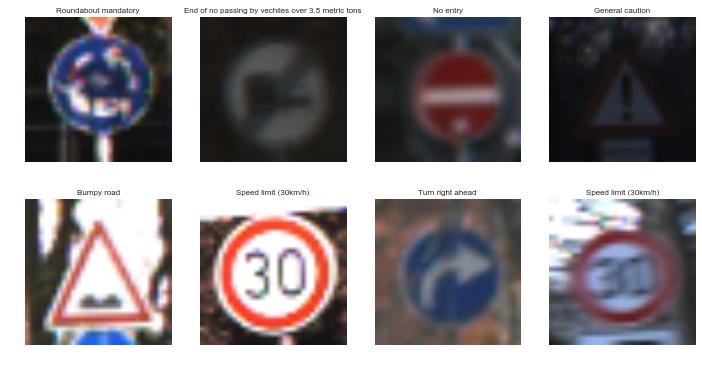

In [10]:
plot_signs(X_train, y_train_names)

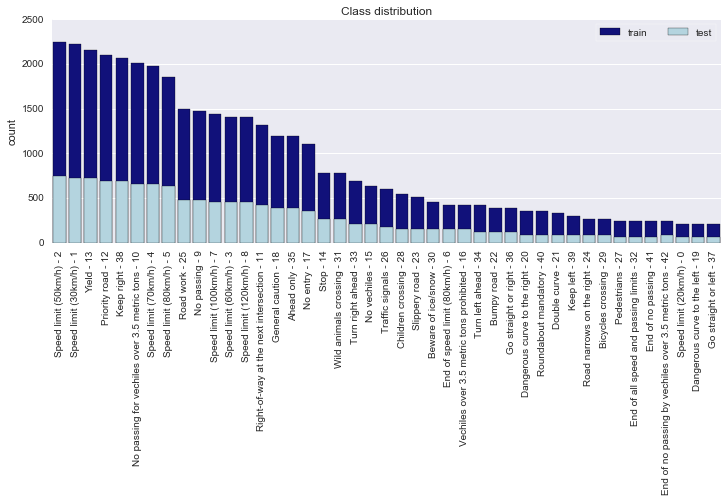

In [11]:
train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))

ax = sns.countplot(x=y_train, order=order, color='darkblue', ax=ax, label="train")

ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

# Preprocessing

In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [13]:
# Normalizes image to 0-1 range
X_train = X_train/255.
X_test = X_test/255.

In [14]:
# Split train data into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.3)

In [15]:
# Setup One-hot encoding
lb = LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))

def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls

In [16]:
# Encode labels
y_train, y_train_cls = one_hot_encoding(y_train, lb)
y_val, y_val_cls = one_hot_encoding(y_val, lb)
y_test, y_test_cls = one_hot_encoding(y_test, lb)

In [17]:
# make sure features are of type float32 not float64
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [18]:
# Shuffel train and validation set
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

In [19]:
# Summary
print("Number of training examples =", len(y_train))
print("Number of validation examples =", len(y_val))
print("Number of testing examples =", len(y_test))

Number of training examples = 27446
Number of validation examples = 11763
Number of testing examples = 12630


# Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D
from sklearn.metrics import accuracy_score
import math

Using TensorFlow backend.


In [21]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 16, 64)    18496       maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 8, 8, 64)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

The following cell will train the model on the training images for multiple rounds (number of epochs). The images will be passed through the model in batches to reduce computing time. 

In [23]:
EPOCHS = 3
BATCH_SIZE = 32

In [24]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          nb_epoch=3,
          verbose=2,
          validation_data=(X_val, y_val),
          shuffle=True)

Train on 27446 samples, validate on 11763 samples
Epoch 1/3
121s - loss: 1.0926 - acc: 0.6770 - val_loss: 0.2318 - val_acc: 0.9275
Epoch 2/3
129s - loss: 0.1216 - acc: 0.9635 - val_loss: 0.0961 - val_acc: 0.9700
Epoch 3/3
130s - loss: 0.0525 - acc: 0.9854 - val_loss: 0.0774 - val_acc: 0.9780


# Test

Now it time to test the model on a complete new data set to verify it's performance and it's ability to generalize. 

In [25]:
# Don't need to change anything below here
predict = model.predict_classes(X_test, verbose=0)
test_acc = accuracy_score(y_test_cls, predict)

In [26]:
print('\nTest Accuracy: %0.2f%%' % test_acc)


Test Accuracy: 0.91%
